# CIFAR-10 Luokitteluprojekti (CNN)

In [1]:
from keras.src.utils import to_categorical
import keras
import numpy as np
from keras import layers
from matplotlib import pyplot as plt

In [2]:
# Load the data and split it between train and test sets
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

# Scale images to the [0, 1] range
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)


#### Modeling

In [3]:
# Create the model
inputs = keras.Input(shape=(32, 32, 3))
x = keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="CIFAR_10_CNN")

In [4]:
model.summary()

Model: "CIFAR_10_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        23,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,442 (165.79 KB)

 Trainable params: 42,442 (165.79 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.1)

Epoch 1/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.3351 - loss: 1.8068 - val_accuracy: 0.5502 - val_loss: 1.3058
Epoch 2/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5258 - loss: 1.3411 - val_accuracy: 0.6066 - val_loss: 1.1412
Epoch 3/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5739 - loss: 1.2073 - val_accuracy: 0.6334 - val_loss: 1.0746
Epoch 4/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6061 - loss: 1.1335 - val_accuracy: 0.6620 - val_loss: 0.9836
Epoch 5/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6268 - loss: 1.0731 - val_accuracy: 0.6708 - val_loss: 0.9815
Epoch 6/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6383 - loss: 1.0420 - val_accuracy: 0.6890 - val_loss: 0.9183
Epoch 7/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6480 - loss: 1.0089 - val_accuracy: 0.6832 - val_loss: 0.9412
Epoch 8/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6623 - loss: 0.9756 - 

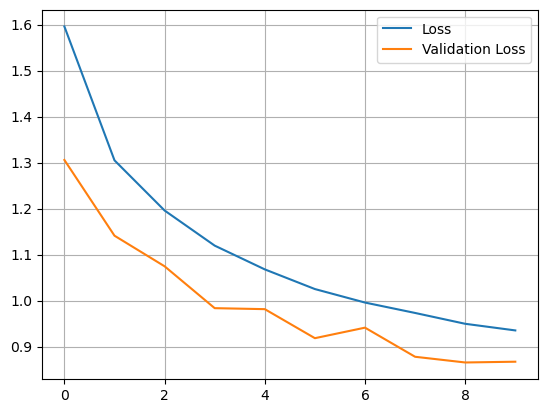

In [6]:
plt.plot(history.history["loss"], label="Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.grid()
plt.show()

In [7]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.8933261632919312
Test accuracy: 0.6948000192642212


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


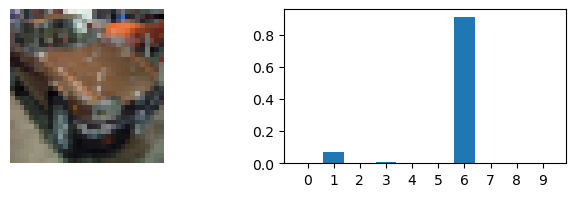

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


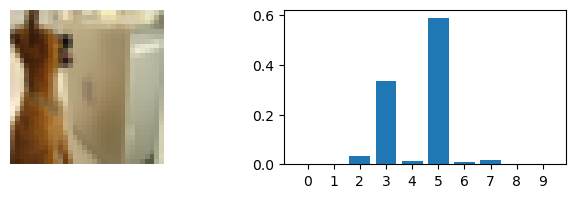

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


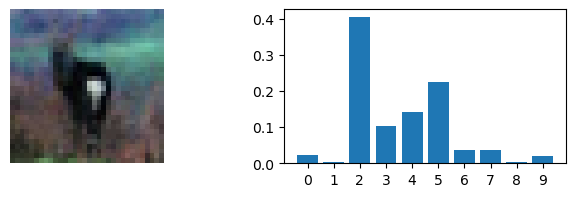

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


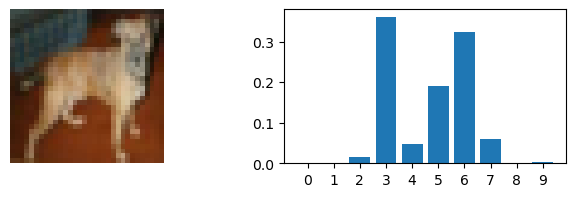

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


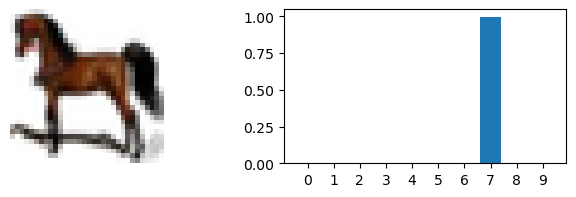

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


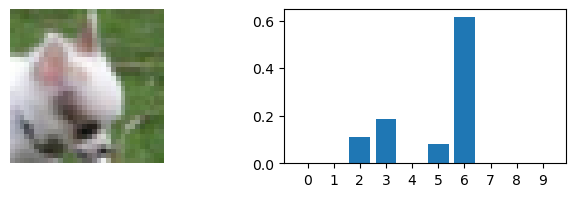

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


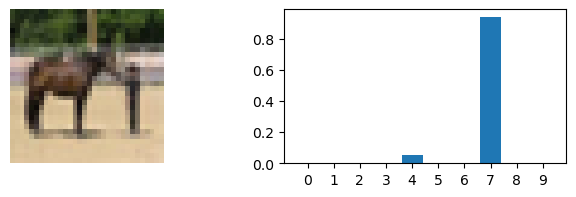

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


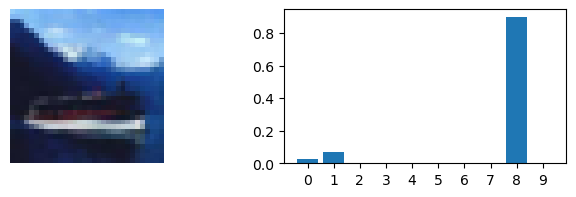

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


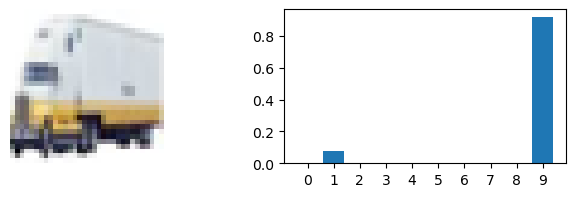

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


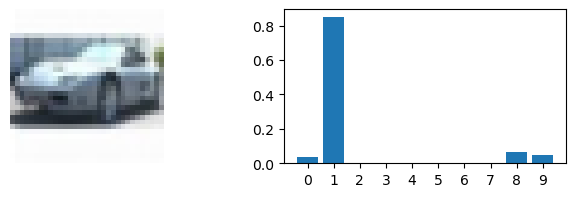

In [8]:
start = 2000

for k in range(10):
    plt.figure(figsize=(8, 2))

    # Get one image
    x = np.expand_dims(X_test[start + k], axis=0)

    # Predict
    y = model.predict(x)[0]

    # Show the image
    plt.subplot(1, 2, 1)
    plt.imshow(X_test[start + k])
    plt.axis("off")

    # Show the prediction probabilities
    plt.subplot(1, 2, 2)
    plt.bar(np.arange(10), y)
    plt.xticks(range(10))

    plt.show()